In [1]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None

image = Image.open("./data/raw/Harmonized_DN_NTL_2018_simVIIRS.tif")
image.show()
image.close()

In [1]:
def get_tif_path(year):
    ext = "simVIIRS.tif" if year > 2013 else "calDMSP.tif"
    return f"./data/raw/Harmonized_DN_NTL_{year}_{ext}"

In [2]:
import geopandas as gpd

usa = gpd.read_file("./data/us-state-boundaries.geojson")

con = usa[~usa['name'].isin(['Alaska', 'Hawaii', 'Guam', 'Commonwealth of the Northern Mariana Islands', 'United States Virgin Islands', 'American Samoa', 'District of Columbia', 'Puerto Rico'])]
con.head()

,gid,arealand,division,intptlat,name,objectid,areawater,intptlon,oid,funcstat,...,state,statens,centlat,basename,mtfcc,region,lsadc,geoid,geo_point_2d,geometry
2,31,1627312771,7,34.895526,Arkansas,44,-1334552525,-92.444626,266078934,A,...,05,00068085,34.894021,Arkansas,G4000,3,00,05,"{ ""lon"": -92.439355745399993, ""lat"": 34.899695...","POLYGON ((-94.55218 36.10224, -94.5862 36.2999..."
3,35,2136109036,5,38.647285,West Virginia,1,489848791,-80.618327,-1929409300,A,...,54,01779805,38.641186,West Virginia,G4000,3,00,54,"{ ""lon"": -80.613701329899996, ""lat"": 38.642578...","POLYGON ((-81.74725 39.09538, -81.74385 39.102..."
4,40,-1616974352,1,41.597419,Rhode Island,6,1323457457,-71.527272,-1861167639,A,...,44,01219835,41.594025,Rhode Island,G4000,1,00,44,"{ ""lon"": -71.524812175999998, ""lat"": 41.594693...","MULTIPOLYGON (((-71.7897 41.72456, -71.79788 4..."
5,54,312831514,9,47.407324,Washington,20,-324557627,-120.575800,-1859906639,A,...,53,01779804,47.414899,Washington,G4000,4,00,53,"{ ""lon"": -120.592673096, ""lat"": 47.41165711690...","POLYGON ((-123.24792 48.28456, -123.11514 48.4..."
6,55,235758874,7,30.863437,Louisiana,21,-2023496089,-91.798717,273332861,A,...,22,01629543,30.902586,Louisiana,G4000,3,00,22,"{ ""lon"": -91.814298479300007, ""lat"": 30.909178...","POLYGON ((-92.06911 33.00816, -91.50012 33.006..."


In [ ]:
import rasterio
from rasterio.mask import mask

for year in range(1992, 2019):

    with rasterio.open(get_tif_path(year)) as src:
        con = con.to_crs(src.crs)

        geoms = con.geometry.values

        out_image, out_transform = mask(src, geoms, crop=True)
        out_meta = src.meta.copy()

    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open(f"./data/processed/US_{year}.tif", "w", **out_meta) as dest:
        dest.write(out_image)

In [3]:
import rasterio
from PIL import Image

image = Image.open("./data/processed/US_2018.tif")
image.show()
image.close()

In [4]:
import numpy as np

with rasterio.open('./data/processed/US_2018.tif') as src:
    night_lights = src.read(1)
    np.nan_to_num(night_lights, nan=0)
    transform = src.transform
    crs = src.crs

In [38]:
threshold = 54
binary_lights = (night_lights > threshold).astype(np.uint8)
t = night_lights.shape[0] * night_lights.shape[1]
print(sum(sum(binary_lights)))
print(sum(sum(binary_lights))/t)

333891
0.01600317829099566


In [39]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Get pixel coordinates where light is above threshold
y_indices, x_indices = np.where(binary_lights == 1)

In [40]:
# Convert pixel indices to geographic coordinates
xs, ys = rasterio.transform.xy(transform, y_indices, x_indices)

In [41]:
coords = np.vstack((xs, ys)).T

In [42]:
# Cluster
db = DBSCAN(eps=0.25, min_samples=500).fit(coords)  # tune eps and min_samples

labels = db.labels_
len(labels[labels > -1])

251244

In [43]:
interstates = gpd.read_file('./data/interstates.geojson')
interstates = interstates[interstates['name'].isin(['I- 95'])]
interstates


,name,geometry
216,I- 95,"MULTILINESTRING ((-76.52969 39.32326, -76.4979..."


In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tab20b = plt.cm.tab20b
tab20b_c = tab20b(np.linspace(0, 1, 115))
np.random.shuffle(tab20b_c)
new = np.vstack(([[1, 1, 1, 0]], tab20b_c))
tab20b_2 = mcolors.ListedColormap(new)

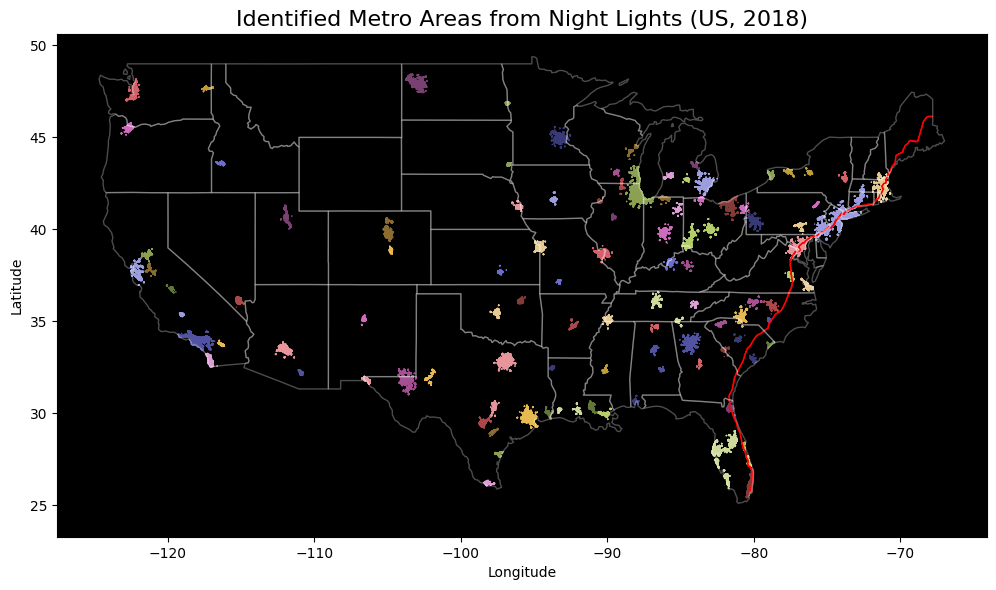

In [52]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

states = gpd.read_file("./data/us-states.json")
cont_states = states[
    ~states['name'].isin([
        'Puerto Rico', 'Guam', 'Alaska', 'Hawaii', 'American Samoa', 'United States Virgin Islands', 'Commonwealth of the Northern Mariana Islands'
    ])
]

fig, ax = plt.subplots(figsize=(12, 12))

interstates_mesh = interstates.to_crs(cont_states.crs)
interstates_mesh.plot(ax=ax, color='red', linewidth=1)

cont_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.3)

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=tab20b_2, s=1, edgecolors='none')

ax.set_title("Identified Metro Areas from Night Lights (US, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()


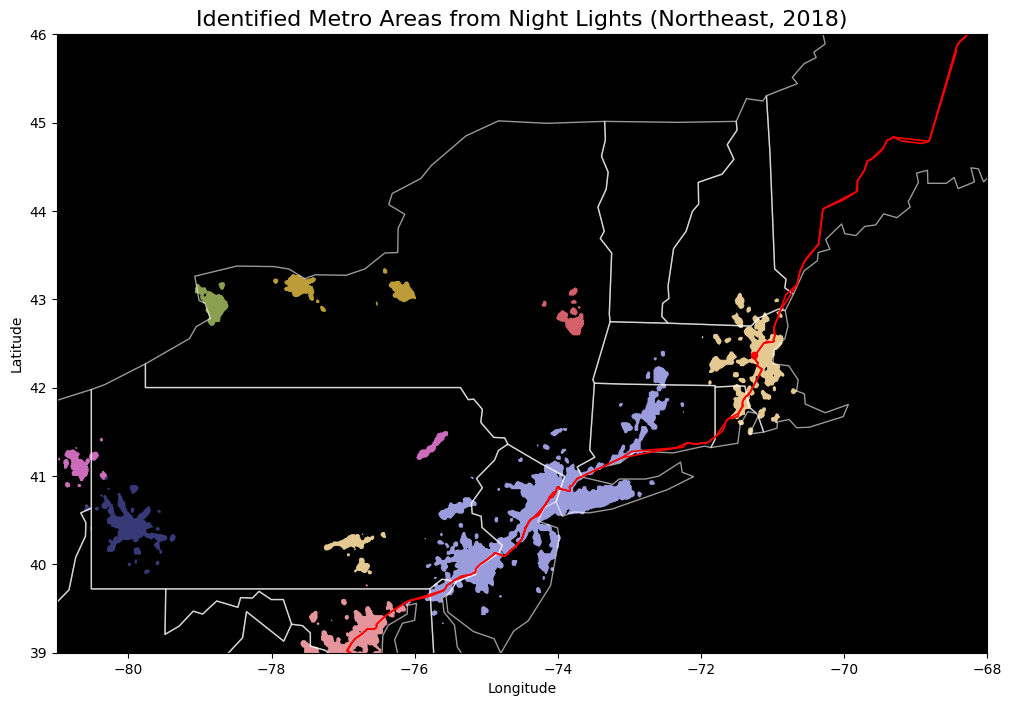

In [53]:
fig, ax = plt.subplots(figsize=(12, 12))

cont_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.6)

interstates_mesh = interstates.to_crs(cont_states.crs)
interstates_mesh.plot(ax=ax, color='red', linewidth=1.2)

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=tab20b_2, s=1, edgecolors='none')
plt.scatter(-71.259742, 42.365664, c='red', s=20) # red dot at Brandeis

ax.set_xlim([-81, -68])
ax.set_ylim([39, 46])

ax.set_title("Identified Metro Areas from Night Lights (Northeast, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()

In [54]:
np.unique(labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105], dtype=int64)

In [55]:
midwest_states = states[
    states['name'].isin([
        'Illinois', 'Wisconsin', 'Indiana', 'Michigan', 'Iowa', 'Missouri', 'Minnesota', 'Ohio', 'Kentucky'
    ])
]

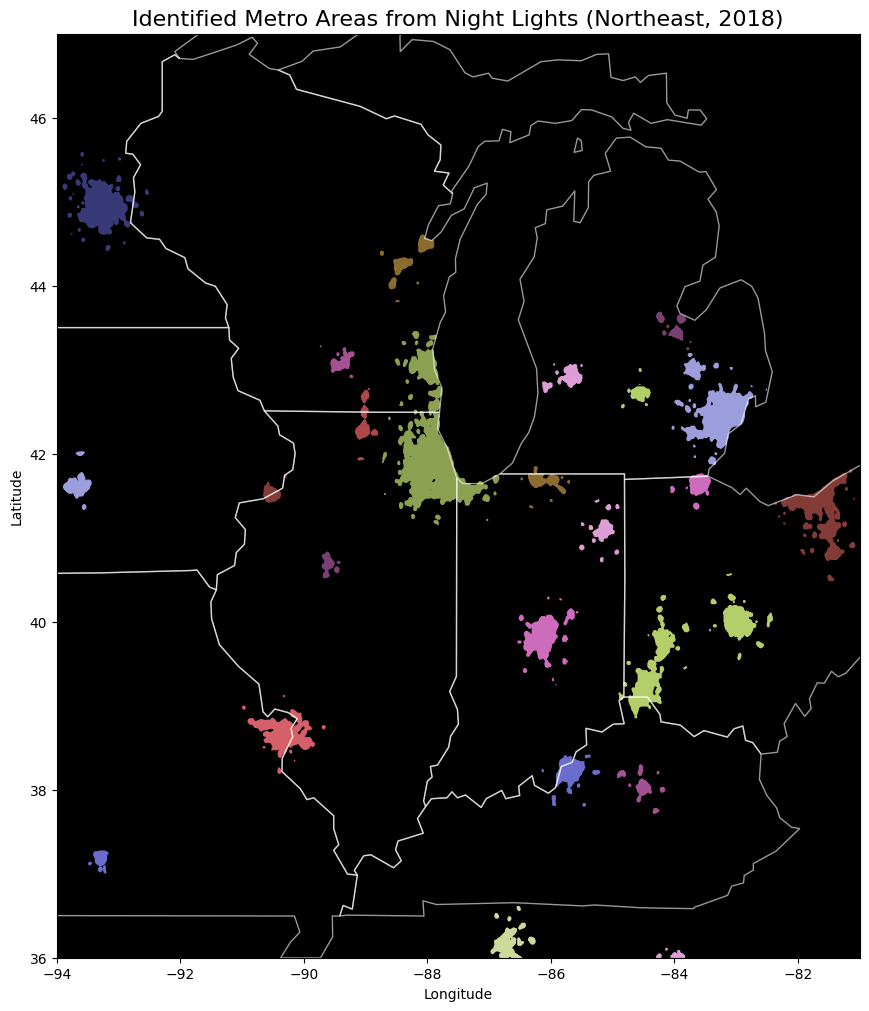

In [56]:
fig, ax = plt.subplots(figsize=(12, 12))

midwest_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.6)

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=tab20b_2, s=1, edgecolors='none')
# plt.scatter(-71.259742, 42.365664, c='red', s=20) # red dot at Brandeis

ax.set_xlim([-94, -81])
ax.set_ylim([36, 47])

ax.set_title("Identified Metro Areas from Night Lights (Northeast, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()

In [57]:
import pandas as pd

points = [(lon, lat) for lon, lat in coords]

brightness = []
with rasterio.open('./data/processed/US_2018.tif') as src:
    for val in src.sample(points):
        brightness.append(val[0])

df = pd.DataFrame({
    'longitude': coords[:, 0],
    'latitude': coords[:, 1],
    'label': labels,
    'brightness': brightness
})

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
gdf

,longitude,latitude,label,brightness,geometry
0,-123.175000,49.000000,-1,56,POINT (-123.175 49)
1,-123.166667,49.000000,-1,59,POINT (-123.16667 49)
2,-123.158334,49.000000,-1,60,POINT (-123.15833 49)
3,-123.150000,49.000000,-1,60,POINT (-123.15 49)
4,-123.141667,49.000000,-1,58,POINT (-123.14167 49)
...,...,...,...,...,...
333886,-81.800000,24.541667,-1,59,POINT (-81.8 24.54167)
333887,-81.791667,24.541667,-1,59,POINT (-81.79167 24.54167)
333888,-81.783334,24.541667,-1,59,POINT (-81.78333 24.54167)
333889,-81.775000,24.541667,-1,58,POINT (-81.775 24.54167)


In [58]:
min_brightness = gdf['brightness'].min()
max_brightness = gdf['brightness'].max()

In [64]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

tab20b = plt.cm.tab20b
tab20b_c = tab20b(np.linspace(0, 1, 115))
np.random.shuffle(tab20b_c)
new = np.vstack(([[1, 1, 1, 0]], tab20b_c))
tab20b_2 = mcolors.ListedColormap(new)

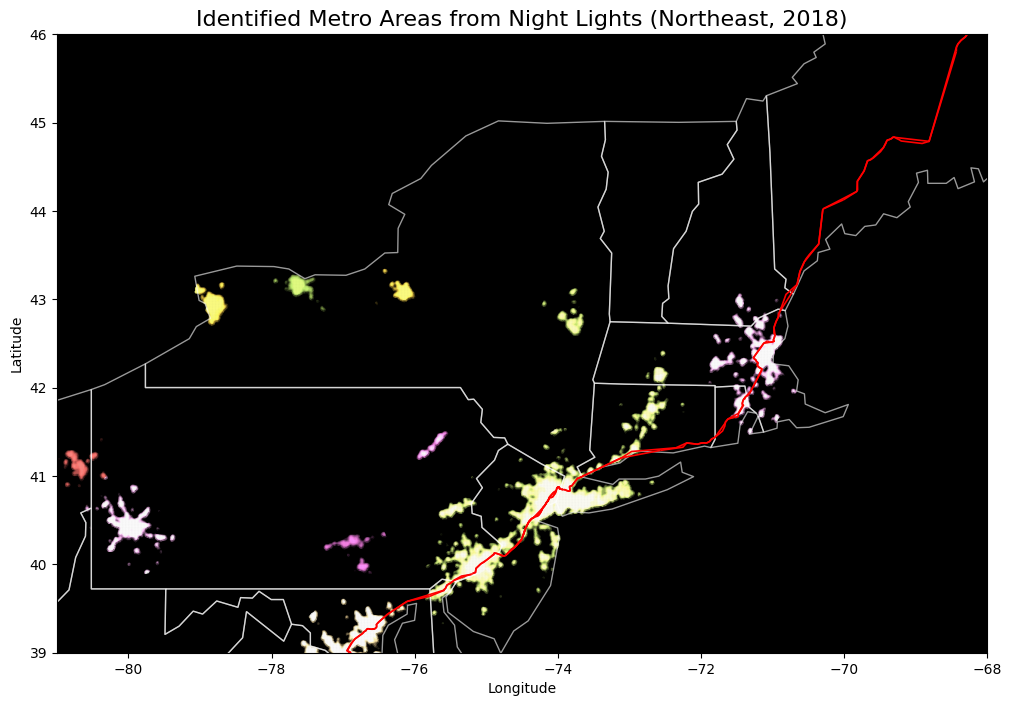

In [59]:
fig, ax = plt.subplots(figsize=(12, 12))

cont_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.6)

def lock(x):
    return min(max(0, x), 1)

def get_label_color(cmap, label, total_labels):
    normalized = label / max(total_labels - 1, 1)
    return cmap(normalized)


interstates_mesh = interstates.to_crs(cont_states.crs)
interstates_mesh.plot(ax=ax, color='red', linewidth=1.2)

for label in gdf['label'].unique():
    if label == -1:
        continue

    subset = gdf[gdf['label'] == label]

    brightness_norm = 2.3 * (subset['brightness'] - min_brightness) / (max_brightness - min_brightness)

    r, g, b, a = mcolors.to_rgba(get_label_color(tab20b_2, label, 116))
    colors = [(lock(r * brightness_norm.iloc[i]), lock(g * brightness_norm.iloc[i]), lock(b * brightness_norm.iloc[i]), a) for i in range(len(subset))]

    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=0.05,
        color=colors
    )

ax.set_xlim([-81, -68])
ax.set_ylim([39, 46])

ax.set_title("Identified Metro Areas from Night Lights (Northeast, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()

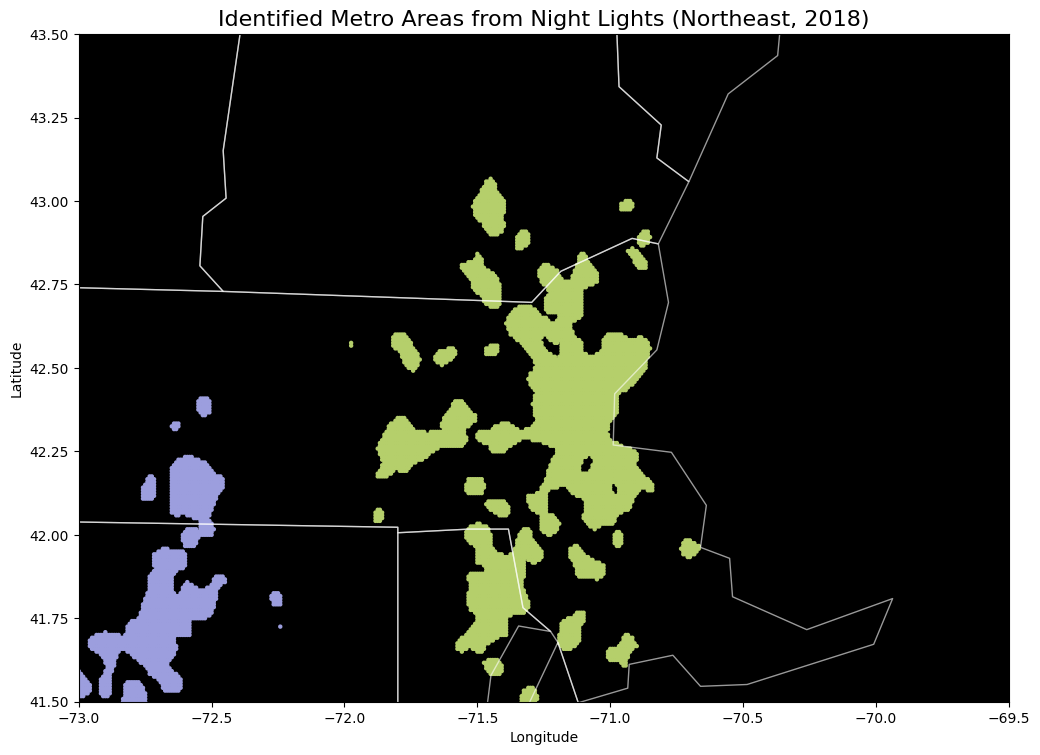

In [81]:
interstates = gpd.read_file('./data/interstates.geojson')

fig, ax = plt.subplots(figsize=(12, 12))

cont_states.boundary.plot(ax=ax, color='white', linewidth=1, alpha=0.6)

# interstates_mesh = interstates.to_crs(cont_states.crs)
# interstates_mesh.plot(ax=ax, color='red', linewidth=1, alpha=0.75)

plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap=tab20b_2, s=10, edgecolors='none')
# plt.scatter(-71.259742, 42.365664, c='red', s=20) # red dot at Brandeis

ax.set_xlim([-73, -69.5])
ax.set_ylim([41.5, 43.5])

ax.set_title("Identified Metro Areas from Night Lights (Northeast, 2018)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('black')
plt.grid(False)


plt.show()